# Genetic diversity and population structure

This notebook examines 4fold genetic diversity in urban and rural populations, urban-rural genetic differentiation ($F_{ST}$ and PCA), and admixtures using ~1X whole-genome sequencing of 2,074 individuals across 26 cities. 

## Setup

In [1]:
# Load packages
library(MASS)
library(tidyverse)
library(car)
library(emmeans)
library(wesanderson)
library(ggrepel)
library(fs)
library(ggridges)
library(data.table)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
# Theme used for plotting
ng1 <- theme(aspect.ratio=0.7,panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(size = 1, color="black"),
          axis.ticks.length=unit(0.25, 'cm'),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=15),
          axis.text.y=element_text(size=15),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
          strip.background = element_rect(colour="black"),
          legend.position = "top", legend.direction="vertical",
          legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
          legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))

In [3]:
# Create directories for figures and tables
paths <- c("../analyses/figures/main_text",
           "../analyses/figures/supplemental",
           "../analyses/tables/")

purrr::walk(paths, dir.create, recursive = T, showWarnings = T)

Warning message in .f(.x[[i]], ...):
“'../analyses/figures/main_text' already exists”Warning message in .f(.x[[i]], ...):
“'../analyses/figures/supplemental' already exists”Warning message in .f(.x[[i]], ...):
“'../analyses/tables' already exists”

In [4]:
# Load in summary datasets rather than re-summarizing from raw data
obs_div_df_wide <- read_csv('../analyses/tables/observed_urban-rural_pi.csv')  # Observed urban-rural thetas
perm_div_df_wide <- read_csv('../analyses/tables/permuted_urban-rural_pi.csv')  # Permuted urban-rural thetas
obs_fst_df <- read_csv('../analyses/tables/observed_fst.csv')  # Observed urban-rural fst
perm_fst_df <- read_csv('../analyses/tables/permuted_fst.csv')  # Permuted urban-rural fst
eigen_df <- read_csv('../analyses/tables/pca_eigen.csv')  # Permuted urban-rural fst


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  city = col_character(),
  tp_scaled_r = col_double(),
  tp_scaled_u = col_double(),
  nSites_r = col_double(),
  nSites_u = col_double(),
  tp_diff = col_double(),
  betaLog_Dist = col_double(),
  pvalLog_Dist = col_double(),
  betaLog_fromGlobalModel = col_double(),
  sig = col_character(),
  sigLog = col_character()
)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  city = col_character(),
  seed = col_double(),
  tp_scaled_r = col_double(),
  nSites_r = col_double(),
  nSites_u = col_double(),
  tp_diff = col_double(),
  betaLog_Dist = col_double(),
  pvalLog_Dist = col_double(),
  betaLog_fromGlobalModel = col_double(),
  sig = col_character()
)


── Column specification ────────────────────────────────────────────────────────────────────────────────

### Functions

In [5]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(path)
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    
    full_path <- paste0(inpath, path)
    
    # Load dataframe
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site) %>% 
    
    # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat) %>% 
        summarise(tp_scaled = mean(tp_scaled),
                  tw_scaled = mean(tw_scaled),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, tp_scaled, tw_scaled, nSites)

    return(df)
    
}

# Function to load permuted diversity estimates by city and habitat
load_permuted_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(dirname(path))
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')

    
    full_path <- paste0(inpath, path)
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site,
               seed = seed) %>% 
        # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat, seed) %>% 
        summarise(tp_scaled = mean(tp_scaled),
                  tw_scaled = mean(tw_scaled),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, seed, tp_scaled, tw_scaled, nSites)

    return(df)
    
}

# Function to estimate P-values
permutation_pval <- function(df, var){
    
    city <- df %>% pull(city) %>% unique
    
    obs_val <- df %>% filter(is.na(seed)) %>% pull(var)
    perm_val <- df %>% filter(!(is.na(seed))) %>% pull(var)

    pval <- sum(abs(perm_val) >= abs(obs_val)) / 100
    df_out <- data.frame(city = city, pval = pval)
    return(df_out)
}

# Function to load observed Fst df by city/habitat
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(path)
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city)
    
    return(df)
    
}

# Function to load permuted Fst df by city/habitat
load_perm_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city,
               seed = seed)
    
    return(df)
    
}

euclidean <- function(x1, y1, x2, y2){
    
    dist <- sqrt((x1 - x2)^2 + (y1 - y2)^2)
    return(dist)
}

pca_importance <- function(x) {
  vars <- x$sdev^2
  vars <- vars/sum(vars)
  rbind(`Standard deviation` = x$sdev, `Proportion of Variance` = vars, 
      `Cumulative Proportion` = cumsum(vars))
}

## Urban and rural pairwise nucleotide diversity

### Load diversity data

#### Observed

In [6]:
# Concatenate urban and rural genetic diversity results (N = 2 habitats x 26 citis = 52) into single dataframe
inpath <- '../../../results/angsd/summary_stats/thetas/by_city/'
obs_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity)

In [7]:
head(obs_div_df)

city,habitat,tp_scaled,tw_scaled,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Albuquerque,r,0.01913512,0.02388864,231866
Albuquerque,u,0.01913369,0.02396646,232617
Antwerp,r,0.01940447,0.02608858,231124
Antwerp,u,0.01970166,0.02521575,232516
Armidale,r,0.01923786,0.02408274,234596
Armidale,u,0.01888040,0.02350858,232859


In [8]:
# Get mean, min, and max number of sites
print(mean(obs_div_df$nSites))
print(range(obs_div_df$nSites))

[1] 229899.8
[1] 191599 236280


In [9]:
# Which cities have min and max sites?
obs_div_df %>% filter(nSites == min(nSites) | nSites == max(nSites))

city,habitat,tp_scaled,tw_scaled,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Hiroshima,r,0.01857428,0.02348932,191599
Toronto,u,0.02023284,0.01981185,236280


In [10]:
# Load logistic slopes from phenotypic analyses
betaLog_df <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_logisticReg_coefs.csv'))
obs_div_df_wide <- obs_div_df %>% 
    # Calculate urban-rural difference in theta
    pivot_wider(names_from = habitat, values_from = c(tp_scaled, tw_scaled, nSites)) %>% 
    mutate(tp_diff = tp_scaled_u - tp_scaled_r) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'),
          sigLog = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, tp_scaled_r, tp_scaled_u, nSites_r, nSites_u, tp_diff, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig, sigLog)
head(obs_div_df_wide)

,city,tp_scaled_r,tp_scaled_u,nSites_r,nSites_u,tp_diff,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig,sigLog
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Albuquerque,0.01913512,0.01913369,231866,232617,-1.431574e-06,-0.839,0.004,-0.425,Significantly negative,Yes
2,Antwerp,0.01940447,0.01970166,231124,232516,2.971930e-04,2.150,0.000,2.142,Significantly positive,Yes
3,Armidale,0.01923786,0.01888040,234596,232859,-3.574697e-04,1.487,0.000,0.320,Significantly positive,Yes
4,Athens,0.01874452,0.01907828,233471,232582,3.337597e-04,1.565,0.000,1.788,Significantly positive,Yes
5,Bogota,0.01875265,0.01896383,226181,231279,2.111750e-04,0.839,0.014,1.325,Significantly positive,Yes
6,Buenos_Aires,0.01843377,0.01838614,231336,233149,-4.762949e-05,0.015,0.950,0.599,Not significant,No


#### Figure 4A

- Mean urban and rural pi with standard errors

In [11]:
# Colors for histograms
pal <- wes_palette('Darjeeling1', 5, type = 'discrete')
urban_col <- pal[4]
rural_col <- pal[2]
cols <- c(urban_col, rural_col)

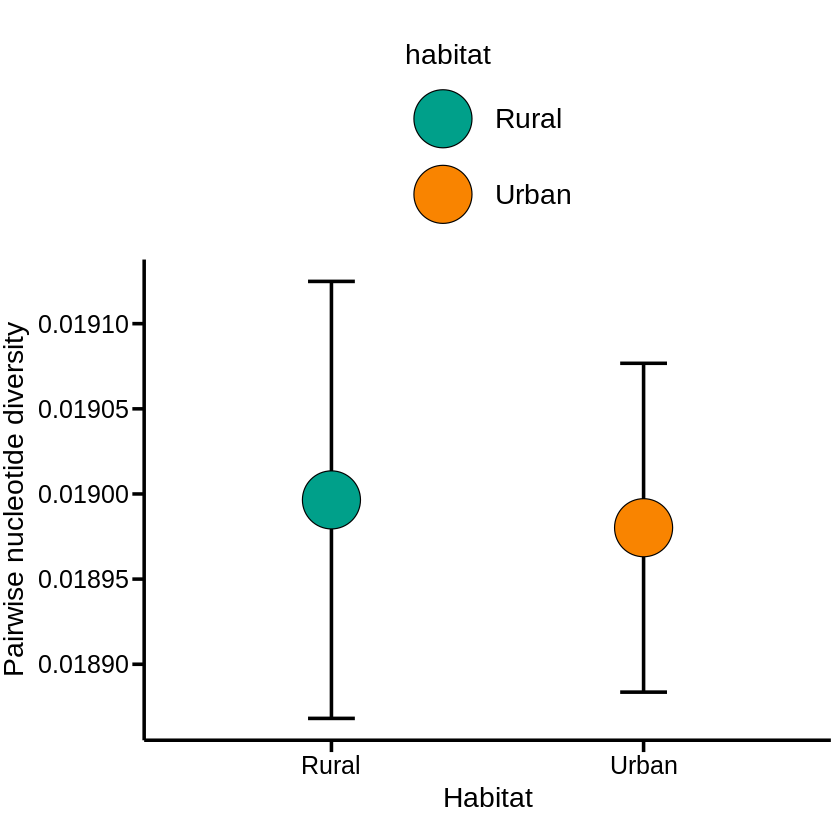

In [12]:
pi_by_habitat <- obs_div_df %>% 
    group_by(habitat) %>% 
    summarise(mean = mean(tp_scaled),
              sd = sd(tp_scaled),
              se = sd / sqrt(n())) %>% 
    mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
    ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
        geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.15, size = 1) +
        geom_point(size = 16, shape = 21) +
        scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
        ylab('Pairwise nucleotide diversity') + xlab('Habitat') +
    ng1
pi_by_habitat

In [13]:
outpath <- '../analyses/figures/main_text/figure4A_observed_pi_byHabitat.pdf'
ggsave(filename = outpath, plot = pi_by_habitat, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [14]:
# Model testing for difference in pi between urban and rural habitats
pi_mod <- aov(tp_scaled ~ city + habitat, data = obs_div_df)
summary(pi_mod)

            Df    Sum Sq   Mean Sq F value   Pr(>F)    
city        25 1.368e-05 5.473e-07   4.447 0.000198 ***
habitat      1 3.000e-09 3.500e-09   0.028 0.868052    
Residuals   25 3.077e-06 1.231e-07                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [15]:
# Least squared means of pi in each habitat
emmeans(pi_mod, specs = 'habitat')

 habitat emmean       SE df lower.CL upper.CL
 r        0.019 6.88e-05 25   0.0189   0.0191
 u        0.019 6.88e-05 25   0.0188   0.0191

Results are averaged over the levels of: city 
Confidence level used: 0.95 

#### Figure 4B

- Slope of HCN cline vs. difference in pi

In [16]:
pal <- c("#909090", "#FF0000", "#046C9A")

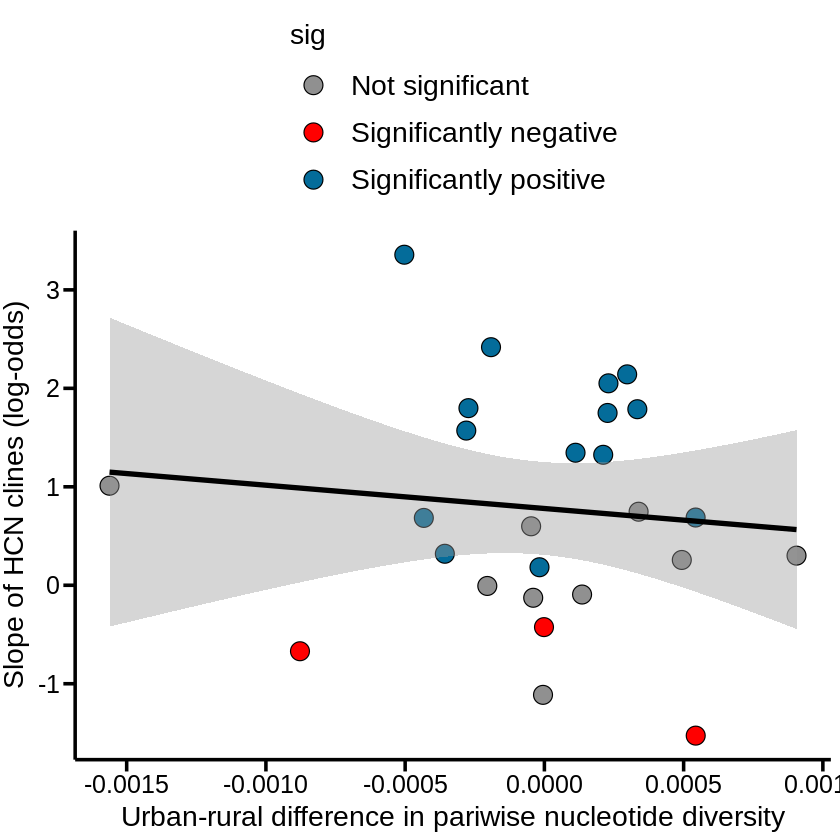

In [17]:
slope_by_PIdiff <- ggplot(obs_div_df_wide, aes(x = tp_diff, y = betaLog_fromGlobalModel)) +
    geom_point(size = 5, aes(fill = sig), shape = 21) +
    geom_smooth(method = 'lm', color = 'black', size = 1.5, formula = y ~ x) +
    scale_fill_manual(values = pal) +
    ylab('Slope of HCN clines (log-odds)') + xlab('Urban-rural difference in pariwise nucleotide diversity') +
    ng1
slope_by_PIdiff

In [18]:
outpath <- '../analyses/figures/main_text/figure4B_betaLog_vs_piDiff.pdf'
ggsave(filename = outpath, plot = slope_by_PIdiff, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [19]:
# Model testing relationship between the slope of clines and the urban-rural difference in pi
div_mod <- aov(betaLog_fromGlobalModel ~ tp_diff, data = obs_div_df_wide)
summary(div_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
tp_diff      1   0.34  0.3443   0.254  0.619
Residuals   24  32.53  1.3554               

In [20]:
# Model testing whether the urban-rural difference in pi varies by whether there is a cline or not
tpDiff_by_sig_mod <- aov(tp_diff ~ sigLog, data = obs_div_df_wide)
summary(tpDiff_by_sig_mod)

            Df   Sum Sq   Mean Sq F value Pr(>F)
sigLog       1 4.00e-09 4.350e-09   0.017  0.897
Residuals   24 6.15e-06 2.562e-07               

In [21]:
emmeans(tpDiff_by_sig_mod, specs = 'sigLog')

 sigLog    emmean       SE df  lower.CL upper.CL
 No      1.45e-06 0.000169 24 -0.000347 0.000350
 Yes    -2.57e-05 0.000123 24 -0.000279 0.000228

Confidence level used: 0.95 

#### Figure SX

- Permuted distribution of difference in pi by city with observed values overlaid

In [22]:
perm_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold_seed.*.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_permuted_pairwise_diversity) 

In [23]:
head(perm_div_df)

city,habitat,seed,tp_scaled,tw_scaled,nSites
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Albuquerque,r,1,0.01907590,0.02438317,232390
Albuquerque,r,10,0.01910077,0.02466234,232303
Albuquerque,r,100,0.01907202,0.02462812,231769
Albuquerque,r,11,0.01921308,0.02471514,232674
Albuquerque,r,12,0.01918768,0.02557561,231491
Albuquerque,r,13,0.01919267,0.02405804,232903


In [24]:
perm_div_df_wide <- perm_div_df %>% 
    # Calculate urban-rural difference in theta
    pivot_wider(names_from = habitat, values_from = c(tp_scaled, tw_scaled, nSites)) %>% 
    mutate(tp_diff = tp_scaled_u - tp_scaled_r) %>% 
    left_join(., betaLog_df, by = 'city')  %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant')) %>% 
    dplyr::select(city, seed, tp_scaled_r, tp_scaled_r, nSites_r, nSites_u, tp_diff, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig)
head(perm_div_df_wide)

,city,seed,tp_scaled_r,nSites_r,nSites_u,tp_diff,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Albuquerque,1,0.01907590,232390,232201,1.799579e-04,-0.839,0.004,-0.425,Significantly negative
2,Albuquerque,10,0.01910077,232303,232309,1.153783e-04,-0.839,0.004,-0.425,Significantly negative
3,Albuquerque,100,0.01907202,231769,232748,1.471660e-04,-0.839,0.004,-0.425,Significantly negative
4,Albuquerque,11,0.01921308,232674,231791,-9.423569e-05,-0.839,0.004,-0.425,Significantly negative
5,Albuquerque,12,0.01918768,231491,232925,-6.062250e-05,-0.839,0.004,-0.425,Significantly negative
6,Albuquerque,13,0.01919267,232903,231480,-1.071175e-04,-0.839,0.004,-0.425,Significantly negative


Picking joint bandwidth of 8.13e-05


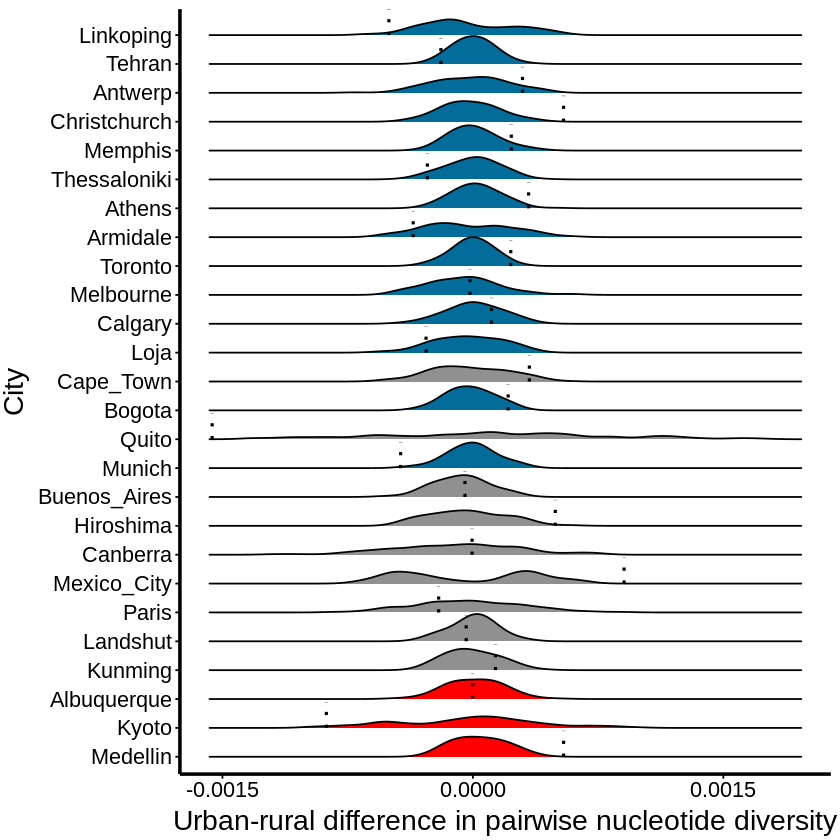

In [25]:
pal <- c("#909090", "#FF0000", "#046C9A")
piDiff_perm_byCity <- perm_div_df_wide %>% 
    ggplot(., aes(x = tp_diff, y = city, fill = sig)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_segment(data = obs_div_df_wide, aes(x = tp_diff, xend = tp_diff, y = as.numeric(as.factor(city)), 
                                             yend = as.numeric(as.factor(city)) + 0.9),
                color = 'black', size = 0.9, linetype = 'dotted') +
    ylab('City') + xlab('Urban-rural difference in pairwise nucleotide diversity') +
    scale_fill_manual(values = pal) +
    scale_x_continuous(breaks = seq(from = -0.015, to = 0.015, by = 0.0015)) +
    theme_classic() + theme(axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"))
piDiff_perm_byCity

In [61]:
outpath <- '../analyses/figures/supplemental/figureSX_piDiff_permutation_byCity.pdf'
ggsave(filename = outpath, plot = piDiff_perm_byCity, device = 'pdf', 
       width = 12, height = 12, units = 'in', dpi = 600, useDingbats = FALSE)

Picking joint bandwidth of 8.13e-05


In [62]:
div_df <- bind_rows(obs_div_df_wide, perm_div_df_wide)
div_pval_df <- div_df %>% 
    group_split(city) %>% 
    purrr::map_dfr(., var = 'tp_diff', permutation_pval) %>% 
    rename('pval_perm' = 'pval')

In [63]:
chsq_pi_df <- obs_div_df_wide %>% 
    left_join(div_pval_df, by = 'city') %>% 
    mutate(sig_perm = ifelse(pval_perm < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, sigLog, sig_perm)

In [64]:
chisq_pi_table <- table(chsq_pi_df$sigLog, chsq_pi_df$sig_perm)
chisq_pi_table

     
      No Yes
  No   6   3
  Yes 12   5

In [65]:
chisq.test(chisq_pi_table)

Warning message in chisq.test(chisq_pi_table):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test with Yates' continuity correction

data:  chisq_pi_table
X-squared = 5.6229e-31, df = 1, p-value = 1


## Urban-rural differentiation

### Fst

#### Observed

In [66]:
# Merge Fst dataframes. Only using Hudson's Fst
inpath <- '../../../results/angsd/summary_stats/hudson_fst/'
obs_fst_df <- list.files(inpath, pattern = '.*_4fold_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_obs_fst) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'),
          sigLog = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No'))  %>% 
    dplyr::select(city, fst, num_sum, denom_sum, nSites, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig, sigLog)


In [67]:
head(obs_fst_df)

,city,fst,num_sum,denom_sum,nSites,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig,sigLog
,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Albuquerque,0.008367866,34.08699,4073.558,229919,-0.839,0.004,-0.425,Significantly negative,Yes
2,Antwerp,0.005988815,24.71576,4126.987,229205,2.150,0.000,2.142,Significantly positive,Yes
3,Armidale,0.006078279,24.88437,4093.983,231597,1.487,0.000,0.320,Significantly positive,Yes
4,Athens,0.009259624,37.42994,4042.275,230919,1.565,0.000,1.788,Significantly positive,Yes
5,Bogota,0.010045507,38.87932,3870.319,224076,0.839,0.014,1.325,Significantly positive,Yes
6,Buenos_Aires,0.007320793,28.64725,3913.134,229923,0.015,0.950,0.599,Not significant,No


In [68]:
# Mean Fst
obs_fst_df %>% 
    summarise(mean = mean(fst),
              sd = sd(fst),
              se = sd / sqrt(n()))

mean,sd,se
<dbl>,<dbl>,<dbl>
0.01193026,0.008459393,0.001659023


In [69]:
# Mean, min, and max number of sites
print(mean(obs_fst_df$nSites))
print(range(obs_fst_df$nSites))

[1] 225785.3
[1] 186401 235166


In [70]:
# Which cities have min and max number of sites
obs_fst_df %>% filter(nSites == min(nSites) | nSites == max(nSites))

city,fst,num_sum,denom_sum,nSites,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig,sigLog
<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Hiroshima,0.044057875,147.96018,3358.314,186401,-0.043,0.842,0.257,Not significant,No
Toronto,0.005500285,24.35982,4428.828,235166,1.463,0.000,1.750,Significantly positive,Yes


#### Figure 4C

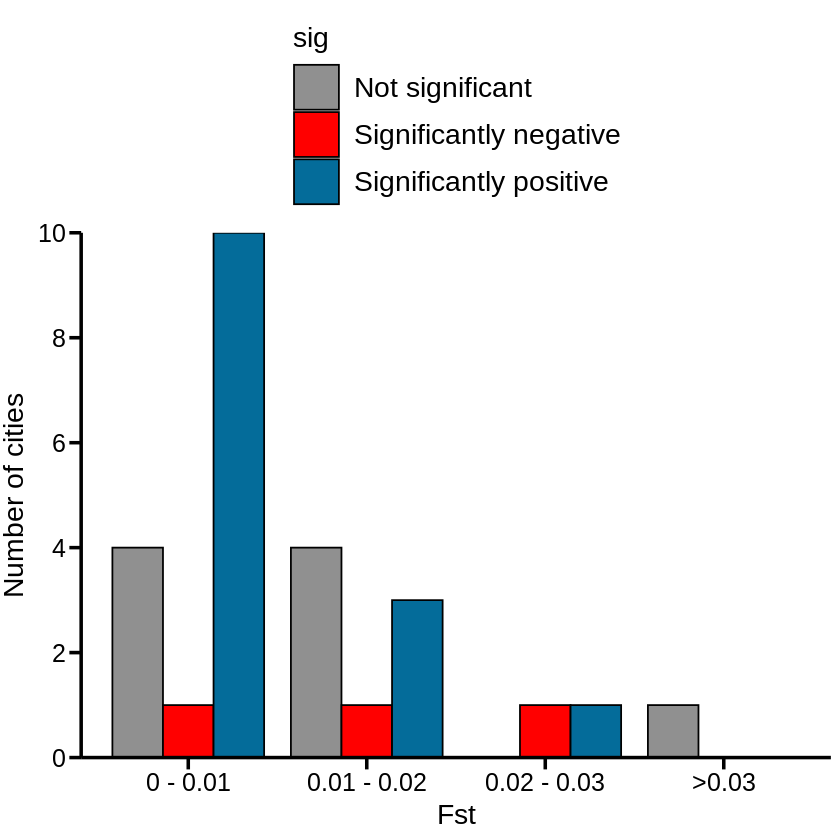

In [71]:
fst_by_cline <- obs_fst_df %>% 
    mutate(bin = case_when(fst > 0 & fst < 0.01 ~ '0 - 0.01',
                           fst > 0.01 & fst < 0.02 ~ '0.01 - 0.02',
                           fst > 0.02 & fst < 0.03 ~ '0.02 - 0.03',
                           fst > 0.03 ~ '>0.03')) %>% 
    mutate(bin = fct_relevel(bin, "0 - 0.01", "0.01 - 0.02", "0.02 - 0.03", ">0.03")) %>% 
#     mutate(sig = fct_relevel(sig, "Significantly negative", "Not significant", "Significantly positive")) %>% 
    group_by(sig, bin) %>% 
    summarise(n = n(), .groups = 'drop') %>% 
    complete(bin, sig, fill = list(n = 0)) %>% 
    ggplot(., aes(x = bin, y = n, fill = sig)) +
    geom_bar(stat = 'identity', color = 'black', width = 0.85, position = 'dodge') +
    scale_fill_manual(values = pal) +
    xlab('Fst') + ylab('Number of cities') +
    scale_y_continuous(breaks = seq(from = 0, to = 10, by = 2), expand = c(0,0)) +
    ng1
fst_by_cline

In [72]:
outpath <- '../analyses/figures/main_text/figure4C_fstCounts_byClineSignificance.pdf'
ggsave(filename = outpath, plot = fst_by_cline, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [73]:
# Model testing whether Fst differs between cities with and without clines
fst_mod <- aov(fst ~ sigLog, data = obs_fst_df)
summary(fst_mod)

            Df    Sum Sq   Mean Sq F value Pr(>F)
sigLog       1 0.0001035 1.035e-04   1.474  0.237
Residuals   24 0.0016855 7.023e-05               

In [74]:
emmeans(fst_mod, specs = 'sigLog')

 sigLog emmean      SE df lower.CL upper.CL
 No     0.0147 0.00279 24  0.00891   0.0204
 Yes    0.0105 0.00203 24  0.00628   0.0147

Confidence level used: 0.95 

#### Figure 4D

- Slope of clines vs. Fst

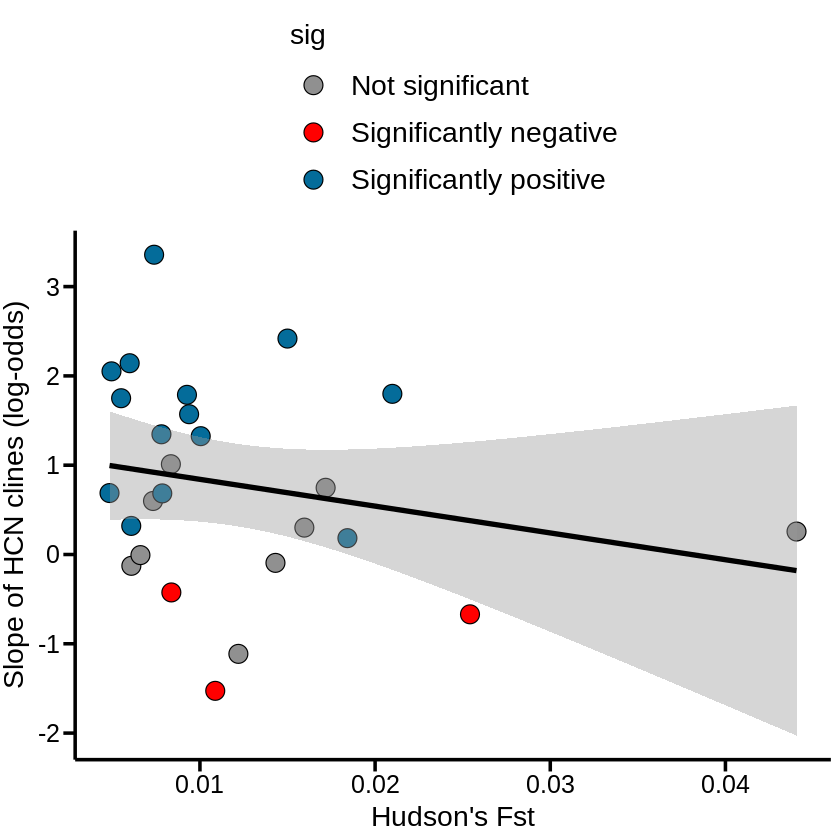

In [75]:
slope_by_fst <- ggplot(obs_fst_df, aes(x = fst, y = betaLog_fromGlobalModel)) +
    geom_point(size = 5, aes(fill = sig), shape = 21) +
    geom_smooth(method = 'lm', color = 'black', size = 1.5, formula = y ~ x) +
    scale_fill_manual(values = pal) +
    scale_y_continuous(breaks = seq(from = -4, to = 4, by = 1)) +
    ylab('Slope of HCN clines (log-odds)') + xlab("Hudson's Fst") +
    ng1
slope_by_fst

In [76]:
outpath <- '../analyses/figures/main_text/figure4D_betaLog_by_fst.pdf'
ggsave(filename = outpath, plot = slope_by_fst, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [77]:
# Model testing whether Fst predicts the strength of clines
fst_mod <- aov(betaLog_fromGlobalModel ~ fst, data = obs_fst_df)
summary(fst_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
fst          1  1.611   1.611   1.237  0.277
Residuals   24 31.263   1.303               

#### Permuted

In [78]:
# Merge Fst dataframes. Only using Hudson's Fst
inpath <- '../../../results/angsd/summary_stats/hudson_fst/'
perm_fst_df <- list.files(inpath, pattern = '.*seed\\d+_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_perm_fst) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant')) %>% 
    dplyr::select(city, seed, fst, num_sum, denom_sum, nSites, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig)

Picking joint bandwidth of 0.000423


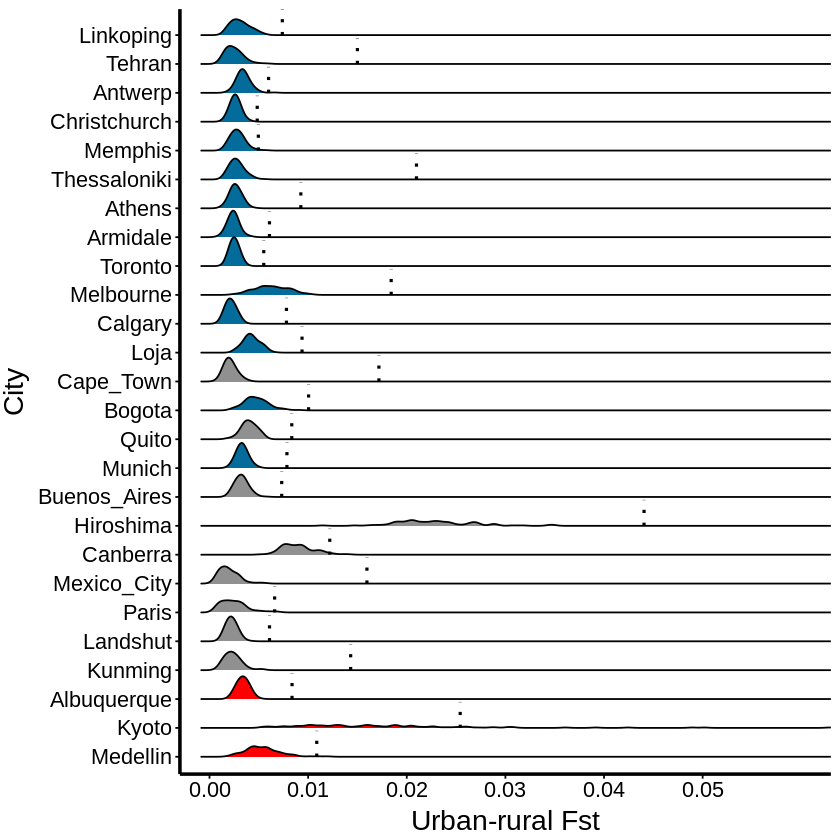

In [79]:
fst_perm_byCity <- perm_fst_df %>% 
    ggplot(., aes(x = fst, y = city, fill = sig)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_segment(data = obs_fst_df, aes(x = fst, xend = fst, y = as.numeric(as.factor(city)), 
                                             yend = as.numeric(as.factor(city)) + 0.9),
                color = 'black', size = 0.9, linetype = 'dotted') +
    ylab('City') + xlab('Urban-rural Fst') +
    scale_fill_manual(values = pal) +
    coord_cartesian(xlim = c(0, 0.06)) +
    scale_x_continuous(breaks = seq(from = 0, to = 0.05, by = 0.01)) +
    theme_classic() + theme(axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"))
fst_perm_byCity

In [80]:
outpath <- '../analyses/figures/supplemental/figureSX_fst_permutation_byCity.pdf'
ggsave(filename = outpath, plot = fst_perm_byCity, device = 'pdf', 
       width = 12, height = 12, units = 'in', dpi = 600, useDingbats = FALSE)

Picking joint bandwidth of 0.000423


In [81]:
fst_df <- bind_rows(obs_fst_df, perm_fst_df)
fst_pval_df <- fst_df %>% 
    group_split(city) %>% 
    purrr::map_dfr(., var = 'fst', permutation_pval) %>% 
    rename('pval_perm' = 'pval')

In [82]:
chsq_fst_df <- obs_fst_df %>% 
    left_join(fst_pval_df, by = 'city') %>% 
    mutate(sig_perm = ifelse(pval_perm < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, sigLog, sig_perm)

In [83]:
chisq_fst_table <- table(chsq_fst_df$sigLog, chsq_fst_df$sig_perm)
chisq_fst_table

     
      No Yes
  No   1   8
  Yes  1  16

In [84]:
chisq.test(chisq_fst_table)

Warning message in chisq.test(chisq_fst_table):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test with Yates' continuity correction

data:  chisq_fst_table
X-squared = 8.169e-32, df = 1, p-value = 1


### Euclidean distance from PCA

- Estimate Euclidean distance between urban and rural centroids by city

In [85]:
# Load data with habitat info
habitat_info <- suppressMessages(
    read_delim(
        '../resources/glue_pc_sampleSheet.txt', 
                           delim = '\t')) %>% 
    dplyr::select(continent, range, city, pop, individual, site, sample)

In [86]:
# Load covariance matrix from PCAngsd
cov_mat <- suppressMessages(
    read_delim(
        '../../../results/population_structure/pcangsd/allSamples/allSamples_4fold_maf0.05_pcangsd.cov', 
                      col_names = FALSE, delim = ' ')) %>% 
      as.matrix()

# Combine continent and habitat data with sample order from ANGSD
samples <- suppressMessages(
    read_table(
        '../../../results/program_resources/bam_lists/finalSamples_4fold_bams.list', col_names = FALSE) %>% 
    rename('sample' = 'X1')) %>%
    mutate(sample = str_extract(sample, '(?<=4fold\\/)\\w+(?=_4fold)')) %>% 
    left_join(., habitat_info, by = 'sample')

In [87]:
head(samples)

sample,continent,range,city,pop,individual,site
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Albuquerque_29_5,NAM,Introduced,Albuquerque,29,5,r
Albuquerque_29_9,NAM,Introduced,Albuquerque,29,9,r
Albuquerque_32_13,NAM,Introduced,Albuquerque,32,13,r
Albuquerque_32_3,NAM,Introduced,Albuquerque,32,3,r
Albuquerque_33_2,NAM,Introduced,Albuquerque,33,2,r
Albuquerque_33_7,NAM,Introduced,Albuquerque,33,7,r


In [88]:
pca_importance(summary(princomp(cov_mat))) %>% 
    as.data.frame() %>% 
    rownames_to_column('var') %>% 
    dplyr::select(var, Comp.1:Comp.4)

var,Comp.1,Comp.2,Comp.3,Comp.4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,0.7188854,0.47964450,0.37329217,0.35081533
Proportion of Variance,0.1686285,0.07506725,0.04546837,0.04015769
Cumulative Proportion,0.1686285,0.24369575,0.28916411,0.32932180


In [89]:
# Dataframe with eigenvectors
eigenvectors <- eigen(cov_mat)
eigen_df <- eigenvectors$vectors %>% 
    as.data.frame() %>% 
    dplyr::select(V1, V2) %>% 
    rename('PC1' = 'V1',
           'PC2' = 'V2') %>% 
    bind_cols(., samples)

In [90]:
euc_dist_df <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2),
             .groups = 'drop') %>% 
    pivot_wider(names_from = site, values_from = c(x, y)) %>% 
    mutate(pca_distance = euclidean(x_u, y_u, x_r, y_r)) %>% 
    dplyr::select(city, pca_distance) %>% 
    left_join(., betaLog_df, by = 'city')

In [91]:
head(euc_dist_df)

city,pca_distance,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,betaLog_fromGlobalModel
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Albuquerque,0.006470112,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,-0.425
Antwerp,0.005173246,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,2.142
Armidale,0.003307576,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,0.320
Athens,0.017485789,-0.586,1.565,0.000,0.295,-1.142,0.000,0.489,-0.858,0.000,North America,1.788
Bogota,0.007531273,-0.865,0.839,0.014,-0.064,-1.087,0.000,-0.296,-0.152,0.598,South America,1.325
Buenos_Aires,0.004265745,1.129,0.015,0.950,1.052,0.220,0.461,1.024,0.271,0.400,South America,0.599


### Does euclidean distance predict HCN?

In [92]:
dist_mod <- aov(betaLog_fromGlobalModel ~ pca_distance, data = euc_dist_df)
summary(dist_mod)

             Df Sum Sq Mean Sq F value Pr(>F)
pca_distance  1   1.15   1.151   0.871   0.36
Residuals    24  31.72   1.322               

#### Figure SX 

- PCA figure with urban/rural centroids

In [93]:
euc_dist_df_forPlot <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2),
             .groups = 'drop')
head(euc_dist_df_forPlot)

city,site,x,y
<chr>,<chr>,<dbl>,<dbl>
Albuquerque,r,0.001076591,0.016321967
Albuquerque,u,0.005727100,0.011823622
Antwerp,r,-0.005840701,0.010520384
Antwerp,u,-0.010582627,0.012588381
Armidale,r,0.013326773,-0.006951741
Armidale,u,0.014177276,-0.010148098


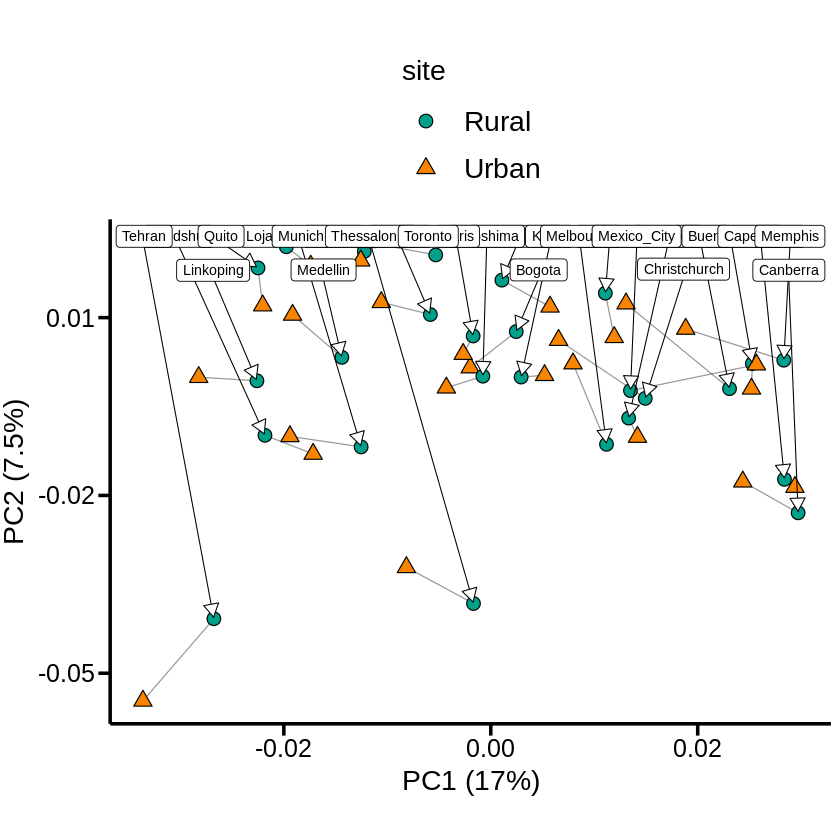

In [94]:
pca_centroids <- ggplot(euc_dist_df_forPlot, aes(x = x, y = y, fill = site, shape = site)) +
    geom_line(size = 0.35, alpha = 0.4, aes(group = city)) +
    geom_point(size = 3.5) +
    scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
    scale_shape_manual(values = c(21, 24), labels = c('Rural', 'Urban')) +
    scale_x_continuous(breaks = seq(from = -0.08, to = 0.06, by = 0.02)) +
    scale_y_continuous(breaks = seq(from = -0.05, to = 0.15, by = 0.03)) +
    ylab('PC2 (7.5%)') + xlab("PC1 (17%)") + 
    geom_label_repel(data = euc_dist_df_forPlot %>% filter(site == 'r'),
                     aes(label = city),
                        color = 'black',
                        fill = 'white', 
                        size = 3,
                        arrow = arrow(length = unit(0.03, "npc"), 
                        type = "closed", ends = "last"),
                        nudge_y = 0.1,
                        segment.size  = 0.3) +
    ng1
pca_centroids

## Urban-rural admixture

In [95]:
# Write summary datasets to disc so analyses can be reproduced without running the pipeline
# This only needs to be run once and datasets with be git controlled and placed in data repositories
write_csv(obs_div_df_wide, '../analyses/tables/observed_urban-rural_pi.csv')
write_csv(perm_div_df_wide, '../analyses/tables/permuted_urban-rural_pi.csv')
write_csv(obs_fst_df, '../analyses/tables/observed_fst.csv')
write_csv(perm_fst_df, '../analyses/tables/permuted_fst.csv')
write_csv(eigen_df, '../analyses/tables/pca_eigen.csv')